# Scoring

In [1]:
import pandas as pd
import respiration.utils as utils

analysis_dir = utils.dir_path('outputs', 'analysis')

frequency_file = utils.file_path(analysis_dir, 'frequency_evaluation.csv')
frequency_df = pd.read_csv(frequency_file)

distances_file = utils.file_path(analysis_dir, 'distance_evaluation.csv')
distances_df = pd.read_csv(distances_file)

In [2]:
# Bigger correlation is better --> 1 - correlation
for idx, row in distances_df.iterrows():
    if row['metric'] != 'pearson':
        continue

    distances_df.at[idx, 'mean'] = 1 - row['mean']

In [3]:
import numpy as np

# Use the absolute value of the correlation
frequency_df['corr'] = frequency_df['corr'].apply(np.abs)

In [4]:
frequency_df['mae_rank'] = frequency_df.groupby('metric')['mae'].rank(ascending=True)
frequency_df['rmse_rank'] = frequency_df.groupby('metric')['rmse'].rank(ascending=True)
frequency_df['corr_rank'] = frequency_df.groupby('metric')['corr'].rank(ascending=False)

distances_df['rank'] = distances_df.groupby('metric')['mean'].rank(ascending=True)

In [5]:
distances_df

,model,metric,mean,rank
0,raft_large,mse,2.145335,34.0
1,raft_large,dtw,37.808165,6.0
2,raft_large,pearson,0.819429,32.0
3,raft_small,mse,2.059649,24.0
4,raft_small,dtw,37.576713,4.0
...,...,...,...,...
106,tf_20240712_163619,dtw,41.655734,9.0
107,tf_20240712_163619,pearson,0.849003,36.0
108,tf_20240713_090928,mse,2.087884,27.0
109,tf_20240713_090928,dtw,44.582698,13.0


In [6]:
metric_ranks = []

for _, row in frequency_df.iterrows():
    model = row['model']
    metric = row['metric']

    metric_ranks.extend([
        {
            'model': model,
            'metric': f'{metric}-mae',
            'rank': row['mae_rank']
        },
        {
            'model': model,
            'metric': f'{metric}-rmse',
            'rank': row['rmse_rank']
        },
        {
            'model': model,
            'metric': f'{metric}-corr',
            'rank': row['corr_rank']
        },
    ])

for _, row in distances_df.iterrows():
    model = row['model']
    metric = row['metric']
    
    if metric == 'mse':
        continue

    metric_ranks.append({
        'model': model,
        'metric': metric,
        'rank': row['rank']
    })

ranks_df = pd.DataFrame(metric_ranks)
ranks_df

,model,metric,rank
0,raft_large,cp-mae,6.0
1,raft_large,cp-rmse,6.0
2,raft_large,cp-corr,6.0
3,raft_large,nfcp-mae,13.0
4,raft_large,nfcp-rmse,15.0
...,...,...,...
513,tf_20240712_113946,pearson,31.0
514,tf_20240712_163619,dtw,9.0
515,tf_20240712_163619,pearson,36.0
516,tf_20240713_090928,dtw,13.0


In [7]:
# Create a dataframe with the ranks of the models where each rank is a column and the model is the index
ranks_df_xxx = ranks_df.pivot(index='model', columns='metric', values='rank')

# Store the ranks in a csv file
ranks_df_xxx.to_csv(utils.file_path(analysis_dir, 'model_ranks.csv'))

In [8]:
optical_flow_models = [
    'FlowNet2',
    'FlowNet2C',
    'FlowNet2CS',
    'FlowNet2CSS',
    'FlowNet2S',
    'FlowNet2SD',
    'lucas_kanade',
    'pixel_intensity',
    'raft_large',
    'raft_small',
]

other_models = set(ranks_df['model'].unique()) - set(optical_flow_models)
other_models

{'20240511_122346',
 '20240511_131436',
 'BP4D_PseudoLabel_DeepPhys',
 'BP4D_PseudoLabel_EfficientPhys',
 'BP4D_PseudoLabel_TSCAN',
 'MA-UBFC_deepphys',
 'MA-UBFC_efficientphys',
 'MA-UBFC_tscan',
 'PURE_DeepPhys',
 'PURE_EfficientPhys',
 'PURE_TSCAN',
 'SCAMPS_DeepPhys',
 'SCAMPS_EfficientPhys',
 'SCAMPS_TSCAN',
 'UBFC-rPPG_DeepPhys',
 'UBFC-rPPG_EfficientPhys',
 'UBFC-rPPG_TSCAN',
 'big_small',
 'mtts_can',
 'random',
 'tf_20240710_142159',
 'tf_20240710_194632',
 'tf_20240710_220756',
 'tf_20240711_194917',
 'tf_20240712_113946',
 'tf_20240712_163619',
 'tf_20240713_090928'}

In [9]:
# Get the mean and standard deviation of the ranks for each model
mean_ranks = ranks_df.groupby('model')['rank'].mean()
std_ranks = ranks_df.groupby('model')['rank'].std()

# Rename the columns
mean_ranks.name = 'score'
std_ranks.name = 'std'

# Merge the mean and standard deviation of the ranks
scores_df = pd.concat([mean_ranks, std_ranks], axis=1)

# Reset the index
scores_df.reset_index(inplace=True)
scores_df

,model,score,std
0,20240511_122346,19.785714,5.793611
1,20240511_131436,22.357143,6.651861
2,BP4D_PseudoLabel_DeepPhys,22.928571,6.719252
3,BP4D_PseudoLabel_EfficientPhys,24.071429,4.480115
4,BP4D_PseudoLabel_TSCAN,24.428571,4.291571
5,FlowNet2,9.428571,4.164212
6,FlowNet2C,6.785714,5.521686
7,FlowNet2CS,5.642857,4.908503
8,FlowNet2CSS,9.357143,4.106414
9,FlowNet2S,7.928571,6.132690


In [10]:
# Show only the other models
scores_df[scores_df['model'].isin(other_models)]

,model,score,std
0,20240511_122346,19.785714,5.793611
1,20240511_131436,22.357143,6.651861
2,BP4D_PseudoLabel_DeepPhys,22.928571,6.719252
3,BP4D_PseudoLabel_EfficientPhys,24.071429,4.480115
4,BP4D_PseudoLabel_TSCAN,24.428571,4.291571
11,MA-UBFC_deepphys,25.928571,10.254187
12,MA-UBFC_efficientphys,28.607143,4.915355
13,MA-UBFC_tscan,26.714286,8.061576
14,PURE_DeepPhys,26.928571,9.401017
15,PURE_EfficientPhys,22.857143,8.456742


<Axes: xlabel='model'>

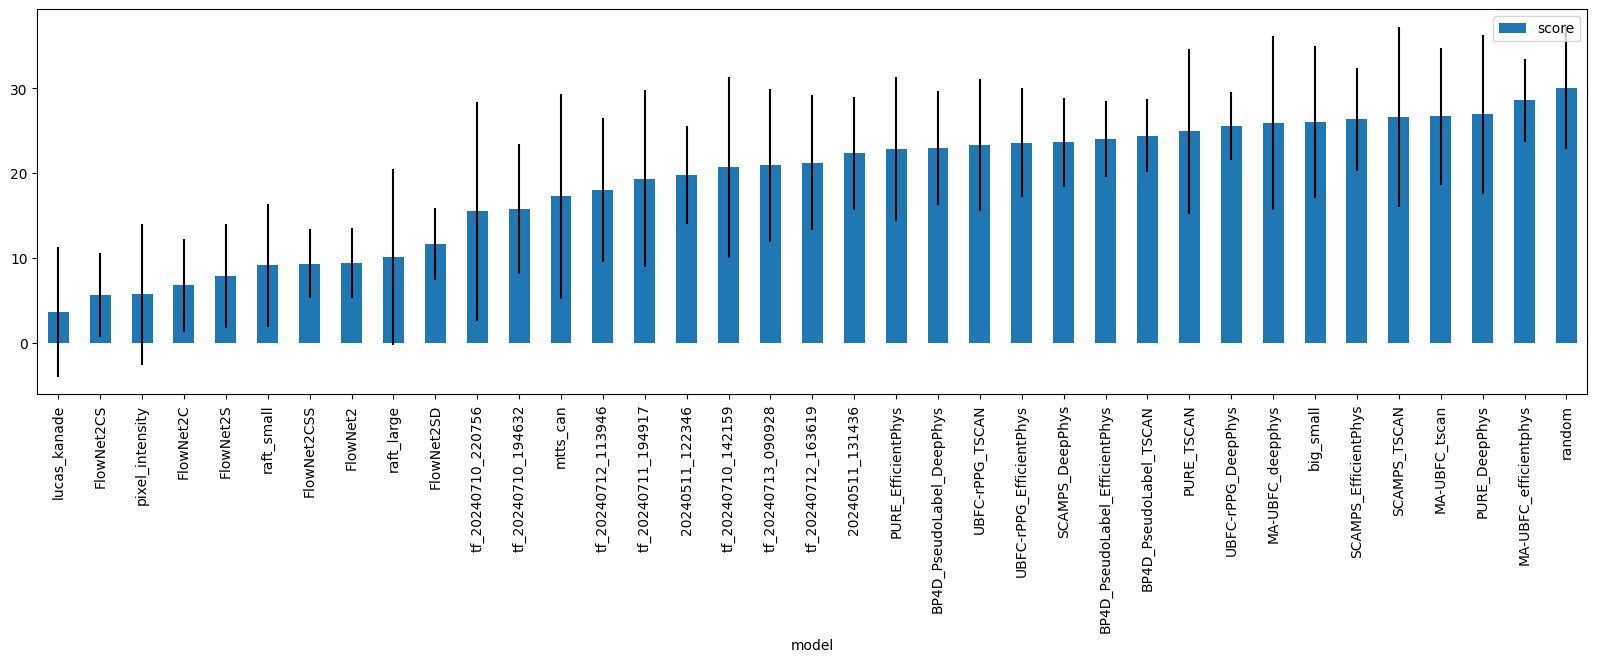

In [12]:
# Sort the standard deviation and plot the results
scores_df.sort_values('score', inplace=True)
scores_df.plot.bar(x='model', y='score', yerr='std', figsize=(20, 5))